# **CNN Fear and Greed Estimator**

![Illustration](./img/panic.png)

This project try to replicate the CNN Fear and Greed Index using various market indicators from the original CNN index and machine learning techniques.

The goal is to build a model that can estimate the Fear and Greed Index based on historical market data, allowing for analysis and insights into market sentiment over time.

The estimation process involves collecting relevant financial data, computing key indicators, and training a machine learning model to predict the index values:
* Data Collection: Gather historical data for key market indicators such as stock prices, volatility indices, bond yields, and market breadth measures.
* Indicator Computation: Calculate relevant indicators that reflect market sentiment, such as momentum, volatility,

Results:  We successfully reconstructed a Fear and Greed index with a correlation of approximately 0.9 to the original CNN Fear and Greed Index over the estimation period from 2025-01-21 to 2026-01-16

The reconstructed index can be used for backtesting trading strategies, risk management, and understanding market dynamics.

## **Config**

In [1]:
import os
import json
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional, Dict, Any, Tuple
from IPython.display import Markdown, display
from sklearn.metrics import r2_score, mean_squared_error, classification_report
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso

In [2]:
pd.options.display.float_format = '{:.6f}'.format
pd.options.display.max_columns = 50
plt.style.use('dark_background')

## **<span style="color:skyblue">Conceptual Framework</span>**

According to CNN Business, the **Fear & Greed Index** is designed to capture the dominant emotion driving U.S. equity markets—**fear** or **greed**—based on a simple behavioral premise: **excessive fear** often pushes prices below “fair” levels, while **excessive greed** can push prices above them. The index converts several observable market behaviors into a single **0–100** score, where **0 = extreme fear** and **100 = extreme greed**.

**1) What the index measures**
CNN frames market sentiment as the aggregation of **seven indicators**, each reflecting a different channel through which risk appetite shows up in prices, flows, and positioning. Each component is interpreted on a **fear ↔ greed** spectrum:

| Component | What it measures | Greed-leaning signal | Fear-leaning signal |
|---|---|---|---|
| **Market Momentum (S&P 500 vs 125-day average)** | S&P 500 level relative to its 125-day moving average | S&P 500 **above** the 125-day moving average (positive momentum) | S&P 500 **below** the 125-day moving average (turning cautious) |
| **Stock Price Strength (NYSE new 52-week highs vs lows)** | Breadth via the balance of NYSE 52-week highs vs lows | Many more **new highs** than **new lows** (broad participation) | Many more **new lows** than **new highs** |
| **Stock Price Breadth (McClellan Volume Summation Index)** | Whether rising-volume outweighs falling-volume across NYSE stocks | Improving/positive breadth (rising-volume dominates) | Weak/negative breadth (falling-volume dominates) |
| **Put/Call Options (5-day average put/call ratio)** | Options positioning / demand for downside protection vs upside exposure | **Lower** put/call ratio (more risk-taking) | **Rising** put/call ratio (more nervousness); values **> 1** often bearish |
| **Market Volatility (VIX vs 50-day average)** | Expected equity volatility via VIX relative to its trend | VIX calmer / **below** trend (greed-leaning regime) | VIX elevated / **above** trend (fear) |
| **Safe Haven Demand (20-day stock returns vs bond returns)** | Preference for safety: stocks vs Treasuries over ~20 days | Stocks outperform bonds (less safe-haven demand) | Treasuries outperform stocks (strong safe-haven demand) |
| **Junk Bond Demand (yield spread: high yield vs investment grade)** | Credit risk appetite via high-yield spread | Spread **narrows** (chasing risk) | Spread **widens** (caution / fear) |

**2) How the score is constructed**
CNN’s methodology treats the index as a **composite sentiment gauge**:
- Each of the seven indicators is transformed into a **standardized sentiment signal** by comparing its **current deviation** from its typical/average behavior to how much it normally fluctuates.
- The final Fear & Greed score is then computed by giving **equal weight** to each component, producing a single number from **0 to 100**.

**3) How to interpret the index**
The index is primarily a **sentiment overlay**, not a standalone trading system:
- **Low readings** suggest widespread risk aversion and defensive positioning (fear).
- **High readings** suggest strong risk appetite and crowded bullish positioning (greed).
Used with fundamentals and risk management, the index can help identify periods when investor emotion may be dominating price action.

## **<span style="color:skyblue">Data and methods</span>**

### **Data sources and overall pipeline**

To recreate a Fear & Greed–type score, we use a **proxy-based approach**. The exact CNN Business inputs are not fully available with free public data (e.g. NYSE 52-week highs/lows breadth, proprietary McClellan volume indicators, and their specific 5-day put/call series). Instead, we approximate the index with **market-based proxies** constructed from liquid, widely available time series:

* Daily prices from Yahoo Finance (`yfinance`):
  `^GSPC` (S&P 500), `^VIX` (VIX), `TLT` (long Treasuries), `RSP` (equal-weight S&P 500 ETF), `HYG` (US high-yield ETF).
* Credit spread and, if available, put/call ratio from the Federal Reserve Bank of St. Louis (FRED):
  ICE BofA US High Yield OAS (`BAMLH0A0HYM2`), and `PUTCALL` for the CBOE put/call ratio.

All series are merged on a **business-day calendar**, forward-filled across holidays and missing quotes. From these prices and spreads we compute **raw indicators**, then transform each raw series into a **0–100 sentiment sub-score** using a rolling **percentile-rank transformation**. Finally, we aggregate the sub-scores into a composite index (equal-weighted by default, or using regression-based weights when calibrating to the CNN Fear & Greed index).

Formally, the workflow is:

1. Collect and align daily prices and spreads.
2. Compute raw components (momentum, breadth, volatility, safe haven, credit risk, etc.).
3. Convert each component into a 0–100 score via rolling percentiles (Greed ↑ / Fear ↓).
4. Average the component scores into a single composite sentiment index.


### **Raw components**

We implement seven core proxies, each designed to mirror CNN’s conceptual components (momentum, breadth, volatility, safe-haven demand, credit risk appetite, etc.), while remaining replicable with public data.

**1. Market momentum (`momentum_spx`)**

CNN defines momentum as the level of the S&P 500 versus its 125-day moving average. We replicate this directly:

$$
momentum\_spx_t
= \frac{SPX_t - MA_{125}(SPX)_t}{MA_{125}(SPX)_t}.
$$

A higher value means the index trades well above its medium-term trend and is interpreted as **Greed**.

**2. Trend / strength proxy (`strength_proxy`)**

CNN’s “stock price strength” uses net 52-week highs vs lows on the NYSE. Since that exact breadth series is not easily accessible, we approximate it with a **longer-horizon trend** of the S&P 500:

$$
strength\_proxy_t
= \frac{SPX_t - MA_{200}(SPX)_t}{MA_{200}(SPX)_t}.
$$

This indicator is highly correlated with momentum but emphasises **long-term trend persistence** rather than short-to-medium-term deviations. Stronger trends indicate **Greed**.

**3. Stock price breadth (`breadth_rsp_spx`)**

CNN’s breadth component is based on the McClellan Volume Summation Index. As a replicable proxy, we focus on the **relative performance of equal-weight vs cap-weight US equities**, capturing how broadly gains are distributed across stocks.

We compare **60-day cumulative returns** of `RSP` (equal-weight S&P 500) and `^GSPC`:

$$
r_{60}^{RSP}(t) = \frac{RSP_t}{RSP_{t-60}} - 1,
\quad
r_{60}^{SPX}(t) = \frac{SPX_t}{SPX_{t-60}} - 1,
$$

$$
breadth\_rsp\_spx_t = r_{60}^{RSP}(t) - r_{60}^{SPX}(t).
$$

When equal-weight outperforms cap-weight (positive spread), performance is **broadly shared** across the index, which we interpret as **Greed**. Negative values signal narrow leadership and more fragile rallies.

**4. Safe haven demand (`safe_haven_20d`)**

CNN defines safe-haven demand as the **20-day relative performance of stocks vs bonds**. We follow this definition directly, using the S&P 500 and long Treasuries (`TLT`):

$$
r_{20}^{SPX}(t) = \frac{SPX_t}{SPX_{t-20}} - 1,
\quad
r_{20}^{TLT}(t) = \frac{TLT_t}{TLT_{t-20}} - 1,
$$

$$
safe\_haven_{20d,t} = r_{20}^{SPX}(t) - r_{20}^{TLT}(t).
$$

* If `safe_haven_20d` is **strongly positive**, equities are outperforming Treasuries over the last month → **risk appetite / Greed**.
* If it is **strongly negative**, Treasuries outperform (flight to safety) → **Fear**.

Compared to a simple price ratio, this **return-based definition** is more stationary and avoids long-term drifts.

**5. Junk bond demand (`junk_bond_mom_20d` and `hy_spread`)**

CNN’s “Junk Bond Demand” measures how willing investors are to hold high-yield (junk) credit relative to safer bonds, via the **yield spread** between high-yield and investment-grade bonds.

We approximate this with two complementary signals:

  * **Yield-spread proxy (`hy_spread`)**
    From FRED, we take the ICE BofA US High Yield Option-Adjusted Spread (`BAMLH0A0HYM2`). A **higher spread** means investors demand more compensation to hold risky credit → **Fear**. A narrower spread implies **Greed**.
    In the scoring step, this component is therefore **inverted** so that higher spreads map to lower scores.

  * **Price-momentum proxy (`junk_bond_mom_20d`)**
    We compute the 20-day return of the high-yield ETF `HYG`:

    $$
    junk\_bond\_mom_{20d,t}
    = \frac{HYG_t}{HYG_{t-20}} - 1.
    $$

    Strong positive performance indicates heavy demand for high-yield credit (**Greed**), while underperformance is associated with **Fear**.

Together, `hy_spread` captures the **risk premium level** in credit markets, while `junk_bond_mom_20d` reflects **recent flows and price momentum** into high-yield bonds.

**6. Market volatility (`vix_rel`)**

CNN compares the VIX to its 50-day moving average. We use the same idea and construct a **relative volatility indicator**:

$$
vix_rel_t = \frac{VIX_t - MA_{50}(VIX)*t}{MA*{50}(VIX)_t}.
$$

* When `vix_rel` is **high and positive**, current volatility is elevated relative to its recent trend → **Fear**.
* When it is **negative**, volatility is calm vs trend → **Greed**.

In the scoring phase, this component is **inverted** so that low relative volatility corresponds to a high score.

**7. Put/call ratio (`put_call`, optional)**

If the CBOE put/call ratio (`PUTCALL`) is available via FRED, we include it directly as a **positioning proxy**:

* A rising put/call ratio (more puts relative to calls) reflects **hedging / fear**.
* A low ratio suggests speculative call buying and **Greed**.

As with volatility and spreads, the score is **inverted**: high put/call values translate into low sentiment scores.

In [3]:
# -----------------------------------
# 1. fonction FRED
# -----------------------------------
def _get_data_fred(path, api_key, series_id, rename):
    path = str(path)
    if os.path.exists(path):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        obs = data.get("observations", [])
        df = pd.DataFrame(obs)
        if df.empty:
            return pd.DataFrame(columns=[rename])
        df["date"] = pd.to_datetime(df["date"])
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
        df = df[['date','value']].rename(columns={'value': rename})
        df = df.set_index("date").sort_index()
        return df
    else:
        try:
            url = "https://api.stlouisfed.org/fred/series/observations"
            params = {
                "series_id": series_id,
                "api_key": api_key,
                "file_type": "json",
            }
            resp = requests.get(url, params=params)
            resp.raise_for_status()
            data = resp.json()
            os.makedirs(os.path.dirname(path), exist_ok=True)
            with open(path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)
            obs = data.get("observations", [])
            df = pd.DataFrame(obs)
            if df.empty:
                return pd.DataFrame(columns=[rename])
            df["date"] = pd.to_datetime(df["date"])
            df["value"] = pd.to_numeric(df["value"], errors="coerce")
            df = df[['date','value']].rename(columns={'value': rename})
            df = df.set_index("date").sort_index()
            return df
        except Exception:
            # Série inconnue / API key / etc. -> retourne vide (on gérera via ffill/skipna)
            return pd.DataFrame(columns=[rename])

# -----------------------------------
# 2. Percentile -> score between 0–100
# -----------------------------------
def percentile_score(
    series: pd.Series,
    invert: bool = False,
    min_periods: int = 252,
    window: int | None = 1260,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
) -> pd.Series:
    """
    Transforme une série en score 0–100 via rang percentile, sans look-ahead.

    - min_periods : nb min d'observations avant de commencer à produire un score
    - window      : taille max de la fenêtre (en points) pour estimer la CDF.
                    None = fenêtre "expanding" (toute l'historique).
                    1260 ~ 5 ans de jours ouvrés.
    - lower_q / upper_q : quantiles pour winsoriser l'historique (robuste aux gros
                          outliers tout en gardant un gradient dans les extrêmes).

    Retourne une série alignée sur 'series' avec des scores dans [0, 100].
    """

    s = series.astype(float).copy()
    scores = pd.Series(index=s.index, dtype=float)

    for i, (idx, val) in enumerate(s.items()):
        if pd.isna(val):
            continue

        # Fenêtre historique : rolling (window) ou expanding si None
        if window is None:
            hist = s.iloc[: i + 1].dropna()
        else:
            start = max(0, i - window + 1)
            hist = s.iloc[start : i + 1].dropna()

        if len(hist) < min_periods:
            continue

        # Winsorisation de l'historique pour limiter l'effet des outliers extrêmes
        if lower_q is not None and upper_q is not None:
            q_low, q_high = hist.quantile([lower_q, upper_q])
            hist = hist.clip(q_low, q_high)

        # La dernière valeur de hist est celle de t (val)
        rank = hist.rank(pct=True).iloc[-1]  # entre 0 et 1
        score = rank * 100.0
        if invert:
            score = 100.0 - score

        scores.loc[idx] = score

    return scores

# -----------------------------------
# 3. Récupération des données marché
# -----------------------------------
def get_yf_close(ticker, start="1990-01-01"):
    data = yf.download(ticker, start=start, progress=False, auto_adjust=False)
    if data is None or len(data) == 0:
        raise ValueError(f"No data returned by yfinance for {ticker}")
    close = data["Close"].copy()
    close.name = ticker
    return close

def build_raw_indicators(
    api_key_fred: str,
    data_dir: str = "data_fred",
    start: str = "1990-01-01",
) -> pd.DataFrame:
    """
    Récupère et assemble les séries brutes nécessaires à l'indice :
      - '^GSPC', '^VIX', 'TLT', 'RSP', 'HYG' via yfinance
      - 'HY_spread' via FRED (BAMLH0A0HYM2)
      - 'put_call' via FRED si disponible (PUTCALL)

    Renvoie un DataFrame journalier business days, ffill sur les jours sans cotation.
    """

    os.makedirs(data_dir, exist_ok=True)

    spx = get_yf_close("^GSPC", start=start)
    vix = get_yf_close("^VIX", start=start)
    tlt = get_yf_close("TLT", start=start)
    rsp = get_yf_close("RSP", start=start)
    hyg = get_yf_close("HYG", start=start)

    # HY spread (BofA High Yield Option-Adjusted Spread)
    hy_path = os.path.join(data_dir, "BAMLH0A0HYM2.json")
    hy_spread = _get_data_fred(
        hy_path,
        api_key_fred,
        series_id="BAMLH0A0HYM2",
        rename="HY_spread",
    )

    # Put/Call ratio (si dispo sur FRED avec ton API)
    pc_path = os.path.join(data_dir, "PUTCALL.json")
    put_call = _get_data_fred(
        pc_path,
        api_key_fred,
        series_id="PUTCALL",
        rename="put_call",
    )

    # Assemblage des prix marché
    df = pd.concat([spx, vix, tlt, rsp, hyg], axis=1)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index().asfreq("B")   # calendrier business
    df = df.dropna(how="all")

    market_cols = ["^GSPC", "^VIX", "TLT", "RSP", "HYG"]
    existing = [c for c in market_cols if c in df.columns]
    if existing:
        df[existing] = df[existing].ffill()

    # Join HY spread et put/call
    df = df.join(hy_spread, how="left")
    df = df.join(put_call, how="left")

    if "HY_spread" in df.columns:
        df["HY_spread"] = df["HY_spread"].ffill()

    if "put_call" in df.columns:
        df["put_call"] = df["put_call"].ffill()

    return df

# -----------------------------------
# 4. Calcul des 7 composantes brutes
# -----------------------------------
def compute_components(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule les composantes brutes de l'indice Fear & Greed.

    Colonnes attendues dans df :
      - '^GSPC' : prix S&P 500
      - '^VIX'  : VIX
      - 'TLT'   : Treasuries long terme
      - 'RSP'   : ETF equal-weight S&P 500 (breadth proxy)
      - 'HYG'   : ETF high yield (junk bond proxy)
      - 'HY_spread' : spread high-yield (FRED)
      - 'put_call'  : ratio put/call (si dispo)

    Retourne un DataFrame 'out' avec :
      - momentum_spx         : (P - MA125) / MA125
      - strength_proxy       : (P - MA200) / MA200
      - breadth_rsp_spx      : surperformance 60 j RSP - SPX
      - junk_bond_mom_20d    : rendement 20 j de HYG
      - hy_spread            : spread HY brut (pour un indicateur de peur)
      - vix_rel              : (VIX - MA50) / MA50
      - safe_haven_20d       : perf_20j SPX - perf_20j TLT
      - put_call             : ratio brut si dispo
    """

    out = pd.DataFrame(index=df.index)

    # 1) Momentum SPX (inchangé)
    ma125 = df["^GSPC"].rolling(125, min_periods=60).mean()
    out["momentum_spx"] = (df["^GSPC"] - ma125) / ma125

    # 2) Strength proxy (toujours MA200 : très corrélé au momentum, mais on le garde)
    ma200 = df["^GSPC"].rolling(200, min_periods=80).mean()
    out["strength_proxy"] = (df["^GSPC"] - ma200) / ma200

    # 3) Breadth : sur-performance 60 j de RSP vs SPX (plus stationnaire qu'un simple ratio de niveaux)
    if "RSP" in df.columns:
        ret_rsp_60 = df["RSP"].pct_change(60)
        ret_spx_60 = df["^GSPC"].pct_change(60)
        out["breadth_rsp_spx"] = ret_rsp_60 - ret_spx_60
    else:
        out["breadth_rsp_spx"] = np.nan

    # 4) Junk bond momentum : rendement 20 j de HYG
    if "HYG" in df.columns:
        out["junk_bond_mom_20d"] = df["HYG"].pct_change(20)
    else:
        out["junk_bond_mom_20d"] = np.nan

    # 5) High-yield spread brut (plus grand = plus de peur, on inversera au scoring)
    out["hy_spread"] = df.get("HY_spread")

    # 6) Volatilité relative : (VIX - MA50) / MA50
    vix = df["^VIX"].astype(float)
    ma_vix_50 = vix.rolling(50, min_periods=20).mean()
    out["vix_rel"] = (vix - ma_vix_50) / ma_vix_50

    # 7) Safe haven demand : différence de performance 20 j actions - Treasuries
    spx_ret_20 = df["^GSPC"].pct_change(20)
    tlt_ret_20 = df["TLT"].pct_change(20)
    out["safe_haven_20d"] = spx_ret_20 - tlt_ret_20

    # 8) Put/Call brut (si présent)
    out["put_call"] = df.get("put_call")

    return out


### **From raw components to 0–100 scores**

Each raw component ($X_t$) is transformed into a **daily sentiment score** ($S_t \in [0,100]$) using a **rolling percentile-rank transform** that avoids look-ahead bias and is robust to outliers.

1. **Historical window.**
   For each date ($t$), we consider a **history of past values** ($\{X_\tau\}_{\tau \le t}$). In practice, we use an expanding window capped at about 5 years of business days (up to $t$, `window=1260`), with a **minimum of 252 observations** before starting to compute scores.

2. **Winsorisation (robustification).**
   Within this window, we **winsorise** the sample at the 1st and 99th percentiles: values below the 1 % quantile are set to that quantile, and values above the 99 % quantile are set to that level. This clips extreme outliers while preserving the relative ordering of “normal” observations.

3. **Percentile score.**
   We then compute the percentile rank of the current observation ($X_t$) within this (winsorised) historical window and map it to a 0–100 scale:
   $$
   S_t = 100 \times \mathrm{rank\_pct}\bigl(X_t \big| \{X_\tau\}_{\tau \le t}\bigr).
   $$
   A value in the top historical percentiles (e.g. > 90 %) translates into a score close to 100, while a value in the bottom percentiles translates into a score close to 0.

4. **Inversion for fear-oriented variables.**
   Some components are naturally **“fear” measures**: high values mean stress (VIX relative to trend, high-yield spread, put/call ratio). For these, we **invert** (cf. `FG_COMPONENT_SPECS`) the score so that all components share the same interpretation “high = Greed, low = Fear”:
   $$
   S^{\text{inv}}_t = 100 - S_t.
   $$

This rolling-percentile approach has two main advantages:

* It is **scale-free**: components measured in different units (price ratios, returns, spreads, volatility levels) become comparable on a common 0–100 scale.
* It is **time-adaptive**: what counts as “extreme greed” or “extreme fear” is always defined **relative to the recent distribution** of each variable, rather than a fixed numerical threshold.

In code, this transformation is implemented by the function `percentile_score(series, invert=..., min_periods=...)`, applied to each raw component.

In [4]:
# ---------------------------------------------
# 5. Specs composantes & Fear/Greed calculation
# ---------------------------------------------
FG_COMPONENT_SPECS = [
    # plus grand = plus de greed
    ("momentum_spx",      False),
    ("strength_proxy",    False),
    ("breadth_rsp_spx",   False),
    ("safe_haven_20d",    False),
    ("junk_bond_mom_20d", False),

    # plus grand = plus de PEUR -> invert=True
    ("put_call",  True),      # + de puts = + de fear
    ("hy_spread", True),      # spread HY plus large = + de fear
    ("vix_rel",   True),      # VIX >> moyenne = + de fear
]

def compute_fear_greed(
    components: pd.DataFrame,
    min_periods: int = 252,
    window: int | None = 1260,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    weights: dict | None = None,
    intercept: float = 0.0,
):
    """
    Calcule les scores 0–100 pour chaque composante + un indice Fear/Greed agrégé.

    - components : DataFrame des composantes brutes (sortie de compute_components)
    - min_periods : nb min d'observations avant de sortir un score
    - window      : taille max de la fenêtre pour la CDF (None = expanding)
    - lower_q / upper_q : quantiles de winsorisation pour la CDF
    - weights     : dict {nom_composante: poids}. None -> moyenne simple.
    - intercept   : biais additif (si calibration sur un index externe).
    """

    scores = pd.DataFrame(index=components.index)

    for name, invert in FG_COMPONENT_SPECS:
        if name not in components.columns:
            continue

        scores[name] = percentile_score(
            components[name],
            invert=invert,
            min_periods=min_periods,
            window=window,
            lower_q=lower_q,
            upper_q=upper_q,
        )

    comp_cols = [c for c in scores.columns if c in dict(FG_COMPONENT_SPECS)]
    if not comp_cols:
        scores["FG_est"] = np.nan
        return scores, "FG_est"

    if weights is None:
        # Moyenne simple des composantes disponibles
        scores["FG_est_mean"] = scores[comp_cols].mean(axis=1)
        name = "FG_est_mean"
    else:
        # Moyenne pondérée calibrée
        w = pd.Series(
            {k: float(v) for k, v in weights.items() if k in comp_cols},
            dtype=float,
        )
        scores["FG_est_cal"] = intercept + (scores[w.index] * w).sum(axis=1)
        name = "FG_est_cal"

    return scores, name

def estimate_fear_greed(
    api_key_fred: str,
    start: str = "1990-01-01",
    out_csv: str | None = None,
    data_dir: str = "data/test",
    min_periods: int = 252,
    window: int | None = 1260,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    weights: dict | None = None,
    intercept: float = 0.0,
):
    """
    Pipeline complet :
      - télécharge / charge les données brutes
      - construit les composantes 'raw_*'
      - calcule les scores 'score_*'
      - calcule l'indice Fear/Greed agrégé

    Retourne un DataFrame avec :
      - raw_<composante>
      - score_<composante>
      - FG_est_mean ou FG_est_cal
    """

    df_raw = build_raw_indicators(api_key_fred, data_dir=data_dir, start=start)
    comps = compute_components(df_raw)

    scores, name = compute_fear_greed(
        comps,
        min_periods=min_periods,
        window=window,
        lower_q=lower_q,
        upper_q=upper_q,
        weights=weights,
        intercept=intercept,
    )

    fg_est = scores[name].copy()
    scores_only = scores.drop(columns=[name], errors="ignore").add_prefix("score_")

    result = pd.concat(
        [comps.add_prefix("raw_"), scores_only, fg_est.rename(name)],
        axis=1,
    )

    # on retire les dates sans indice agrégé
    result = result.dropna(subset=[name])

    if out_csv is not None:
        out_csv = str(out_csv)
        os.makedirs(os.path.dirname(out_csv), exist_ok=True)
        result.to_csv(out_csv)

    return result


### **Composite Fear & Greed proxy**

Once all component scores are computed, we construct a **composite sentiment index** ($FG_t$) in two ways:
1. **Theoretical index (equal weights).**
   By default, we define:
   $$
   FG^{\text{mean}}_t = \frac{1}{K} \sum_{k=1}^K S_{k,t},
   $$
   where ($S_{k,t}$) is the score of component $k$ at date $t$ and $K$ is the number of available components. This equal-weighted average reflects a **model-driven view** in which each channel (momentum, breadth, volatility, safe-haven demand, credit risk, positioning) contributes symmetrically to overall sentiment.

2. **Calibrated index (regression weights).**
   To benchmark against the **CNN Fear & Greed index**, we also estimate a **linear regression model** of the form:
   $$
   FG^{\text{CNN}}_t \approx \alpha + \sum_{k=1}^K \beta_k S_{k,t},
   $$
   fitted on periods where the official CNN index is available. The estimated intercept $\hat\alpha$ and coefficients $\hat\beta_k$ define a **weighted composite**:
   $$
   FG^{\text{cal}}_t = \hat\alpha + \sum_{k=1}^K \hat\beta_k S_{k,t}.
   $$
   This calibrated version is optimised to **track the historical CNN index** as closely as possible, while still being fully transparent and replicable.

In both cases, the resulting index is rescaled to lie in $[0,100]$, with the conventional interpretation:

* 0  → **extreme fear**,
* 50 → **neutral / balanced**,
* 100 → **extreme greed**.

This design yields a sentiment estimator that is:

* **Transparent** (built from clearly defined market proxies),
* **Reproducible** with public data, and
* **Flexible**, since we can work either with the equal-weight “theoretical” index or with a calibrated version that closely mimics the CNN Fear & Greed index for empirical applications and decision-making.

In [5]:
from dotenv import load_dotenv
load_dotenv()

API_KEY = os.getenv("API_KEY", "")

fg_df = estimate_fear_greed(
    API_KEY,
    start="1995-01-01",
    window=1260,
    out_csv="data/fg_estimation.csv",
    data_dir="data/fred_cache",
)

fg_df

c:\Users\aurel\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\scrapers\history.py:173: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\aurel\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\scrapers\history.py:173: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\aurel\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\scrapers\history.py:173: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\aurel\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\scrapers\history.py:173: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('

,raw_momentum_spx,raw_strength_proxy,raw_breadth_rsp_spx,raw_junk_bond_mom_20d,raw_hy_spread,raw_vix_rel,raw_safe_haven_20d,raw_put_call,score_momentum_spx,score_strength_proxy,score_breadth_rsp_spx,score_safe_haven_20d,score_junk_bond_mom_20d,score_put_call,score_hy_spread,score_vix_rel,FG_est_mean
Date,,,,,,,,,,,,,,,,,
1996-01-26,0.054544,0.092230,NaN,NaN,NaN,-0.043489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.015873,73.015873
1996-01-29,0.058028,0.095691,NaN,NaN,NaN,-0.027166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.426877,64.426877
1996-01-30,0.067046,0.104898,NaN,NaN,NaN,-0.008573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.511811,55.511811
1996-01-31,0.075860,0.113914,NaN,NaN,NaN,0.000144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.411765,49.411765
1996-02-01,0.078827,0.116882,NaN,NaN,NaN,0.009271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.140625,44.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-16,0.040461,0.091917,0.013072,0.006579,2.650000,-0.070449,0.032520,NaN,44.523810,60.873016,73.730159,63.015873,69.285714,NaN,98.571429,58.253968,66.893424
2026-01-20,0.018405,0.068448,0.018322,0.001238,2.730000,0.174607,0.021059,NaN,30.396825,45.000000,78.730159,52.539683,51.825397,NaN,95.317460,13.809524,52.517007
2026-01-21,0.029568,0.079574,0.025044,0.009457,2.690000,-0.008891,0.008758,NaN,35.555556,51.984127,84.523810,39.920635,77.777778,NaN,96.468254,42.142857,61.196145


## **<span style="color:skyblue">EDA</span>**

### **<span style="color:blue">Core components</span>**

Here we can observe:

* **7 547 observations** journalières (business days), de 1995-12-29 à 2026-01-21.
* **3 blocs de variables** : `raw_*` (indicateurs bruts), `score_*` (scores 0–100) et `FG_est_mean` (indice composite).
* **Couverture des séries** :

  * Put/Call totalement manquant (`score_put_call` : 0/7 547 non-nuls) → composante options absente.
  * Junk bond demand très incomplet (`raw_junk_bond_mom_20d` : 37.6 % de manquants ; `score_junk_bond_mom_20d` : 40.9 %) → HYG commence tard + période de chauffe pour les scores.
  * Breadth RSP (`raw_breadth_rsp_spx`) et Safe haven TLT (`raw_safe_haven_20d`) partiels, avec respectivement 25.0 % et 22.0 % de valeurs manquantes (scores : 28.3 % et 25.3 %) → ETF proxies indisponibles sur tout l’historique.
  * HY spread presque complet (`raw_hy_spread` : seulement 3.1 % manquants ; `score_hy_spread` : 6.4 %).
* **Bruts marquants** :

  * `raw_hy_spread` : médiane 4.55 pts, max 21.82 pts → gros pics de prime de risque en période de crise.
  * `raw_vix_rel` : médiane –0.032 (VIX ≈ 3 % sous sa moyenne 50 j), max 2.45 (VIX ≈ 245 % au-dessus de sa moyenne) → épisodes de stress extrême.
* **Scores** : la plupart des composantes sont bien centrées autour de 50 (`score_momentum_spx` ≈ 48.9, `score_strength_proxy` ≈ 48.6, `score_safe_haven_20d` ≈ 50.2, `score_junk_bond_mom_20d` ≈ 49.8, `score_vix_rel` ≈ 50.4), avec une breadth un peu plus basse (≈ 43.6) et un score HY spread légèrement biaisé vers la “Greed” (≈ 54.5).

In [6]:
print(fg_df.info())
fg_df.describe()

<class 'pandas.DataFrame'>
DatetimeIndex: 7547 entries, 1996-01-26 to 2026-01-23
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   raw_momentum_spx         7547 non-null   float64
 1   raw_strength_proxy       7547 non-null   float64
 2   raw_breadth_rsp_spx      5660 non-null   float64
 3   raw_junk_bond_mom_20d    4708 non-null   float64
 4   raw_hy_spread            7312 non-null   float64
 5   raw_vix_rel              7547 non-null   float64
 6   raw_safe_haven_20d       5890 non-null   float64
 7   raw_put_call             0 non-null      object 
 8   score_momentum_spx       7507 non-null   float64
 9   score_strength_proxy     7487 non-null   float64
 10  score_breadth_rsp_spx    5409 non-null   float64
 11  score_safe_haven_20d     5639 non-null   float64
 12  score_junk_bond_mom_20d  4457 non-null   float64
 13  score_put_call           0 non-null      float64
 14  score_hy_spread  

,raw_momentum_spx,raw_strength_proxy,raw_breadth_rsp_spx,raw_junk_bond_mom_20d,raw_hy_spread,raw_vix_rel,raw_safe_haven_20d,score_momentum_spx,score_strength_proxy,score_breadth_rsp_spx,score_safe_haven_20d,score_junk_bond_mom_20d,score_put_call,score_hy_spread,score_vix_rel,FG_est_mean
count,7547.000000,7547.000000,5660.000000,4708.000000,7312.000000,7547.000000,5890.000000,7507.000000,7487.000000,5409.000000,5639.000000,4457.000000,0.000000,7061.000000,7547.000000,7547.000000
mean,0.021043,0.034030,0.000630,-0.000638,5.207638,0.006902,0.007118,48.912710,48.601937,43.645863,50.183946,49.803869,NaN,54.476408,50.446995,48.388506
std,0.062421,0.080654,0.025997,0.030229,2.533809,0.203711,0.062449,30.682453,30.858465,29.934903,28.502536,27.418079,NaN,35.192331,29.642199,21.148091
min,-0.361267,-0.396457,-0.100938,-0.259348,2.410000,-0.418016,-0.428011,0.555556,0.555556,0.555556,0.555556,0.555556,NaN,0.383142,0.354610,0.354610
25%,-0.006495,-0.001877,-0.011695,-0.010783,3.520000,-0.115146,-0.021756,20.873016,19.285714,16.904762,26.642021,26.984127,NaN,21.625544,24.603175,33.034318
50%,0.031631,0.049399,0.001117,0.001403,4.550000,-0.032379,0.013349,50.079365,51.269841,39.761905,49.761905,50.555556,NaN,56.706349,50.555556,51.742922
75%,0.060732,0.086506,0.014037,0.010514,6.162500,0.080851,0.044693,75.396825,75.030562,69.126984,74.700413,71.945701,NaN,90.714286,76.349206,65.158376
max,0.188133,0.206235,0.181193,0.240898,21.820000,2.447977,0.246237,99.584200,99.569892,99.554896,99.523810,99.606299,NaN,99.444444,99.444444,97.753703


In [7]:
def plotter(df, x, y, title="", ylabel="", figsize=(14, 5), 
            legend=False, marker=None, style=None, color='blue'):
    plt.figure(figsize=figsize)
    if marker is None and style is None:
        plt.plot(x, df[y], color)
    elif style is None:
        plt.plot(x, df[y], color, marker=marker)
    elif marker is None:
        plt.plot(x, df[y], color, style=style)
    else:
        plt.plot(x, df[y], color, marker=marker, style=style)
    plt.title(title, loc='left', fontsize=16, weight='bold')
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.7, linestyle='--')
    for sp in plt.gca().spines.values():
        sp.set_visible(False)
    if legend:
        plt.legend()
    ax = plt.gca()
    ax.tick_params(axis="x", which="both", length=0)
    plt.show()

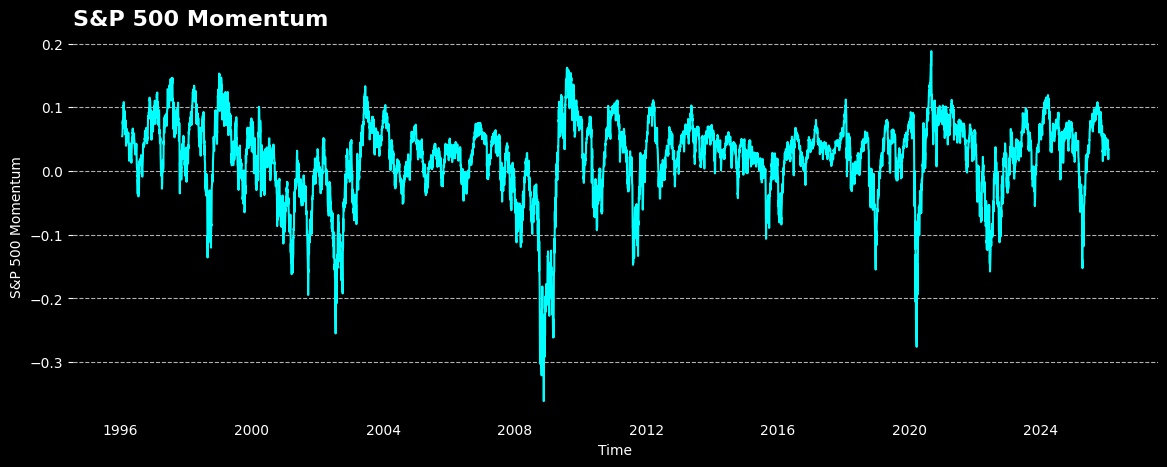

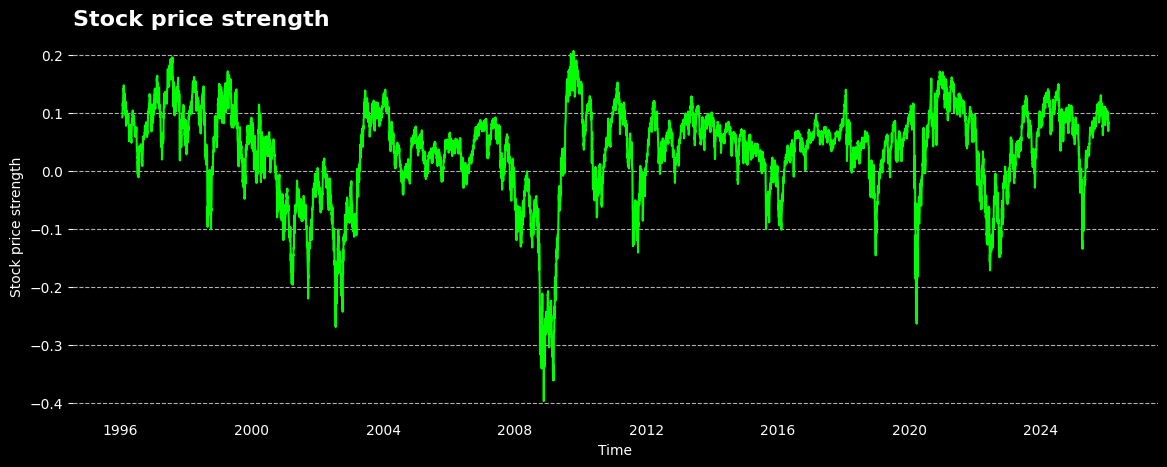

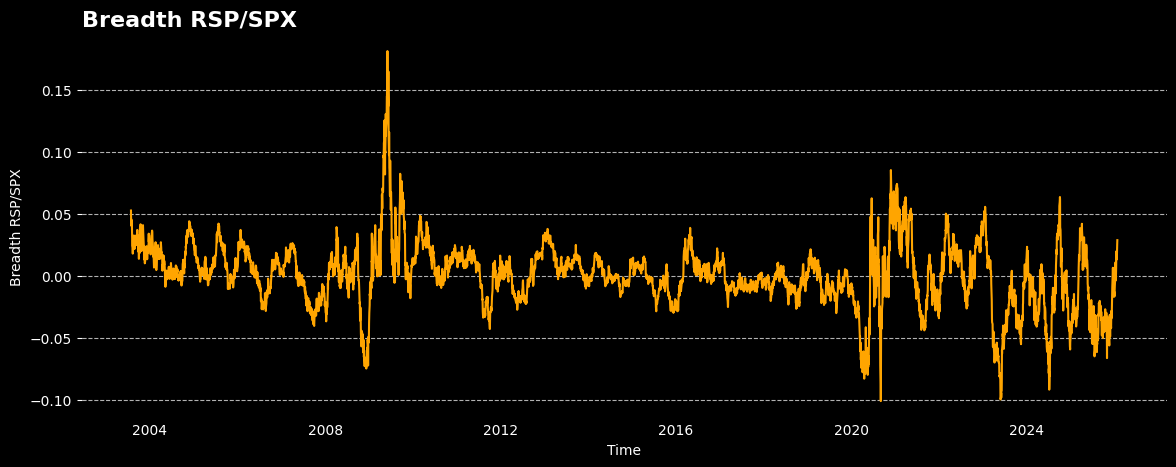

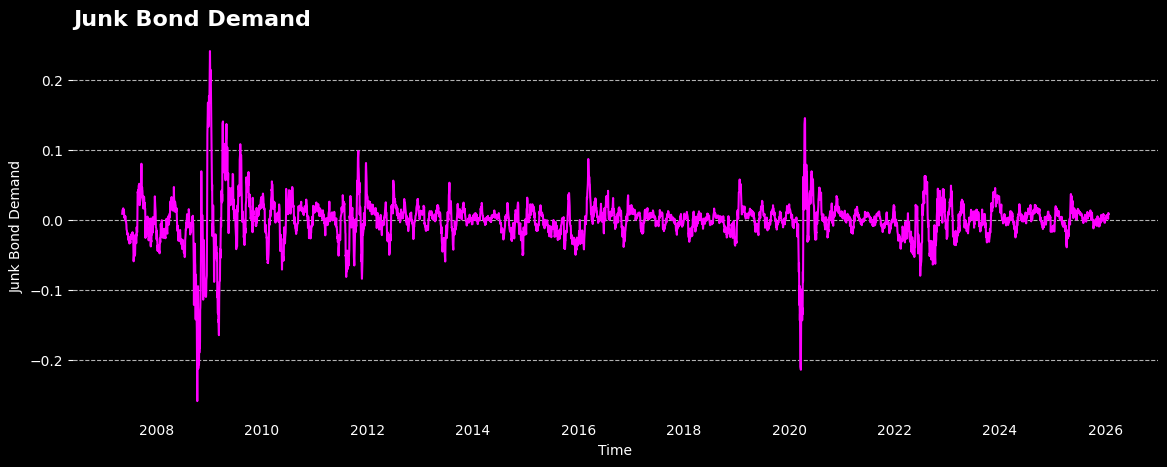

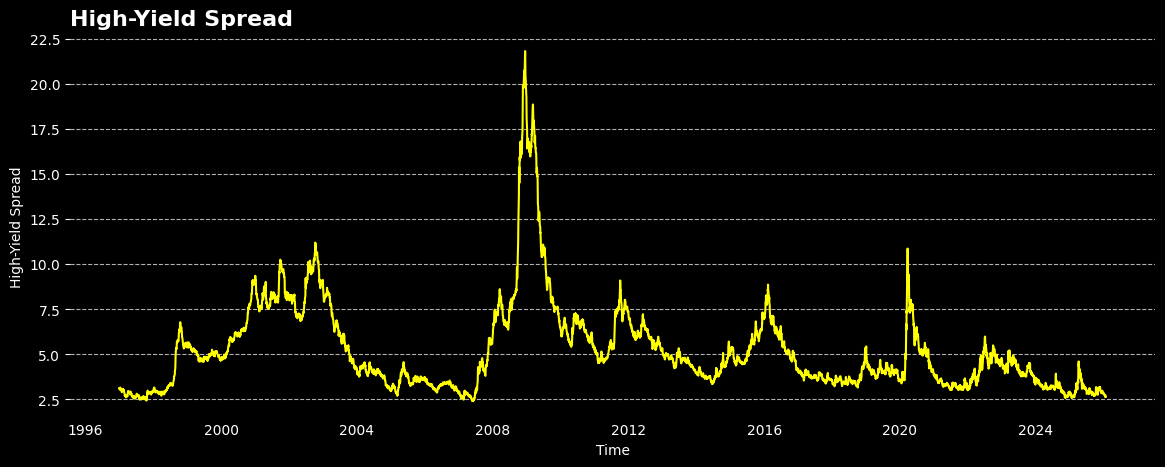

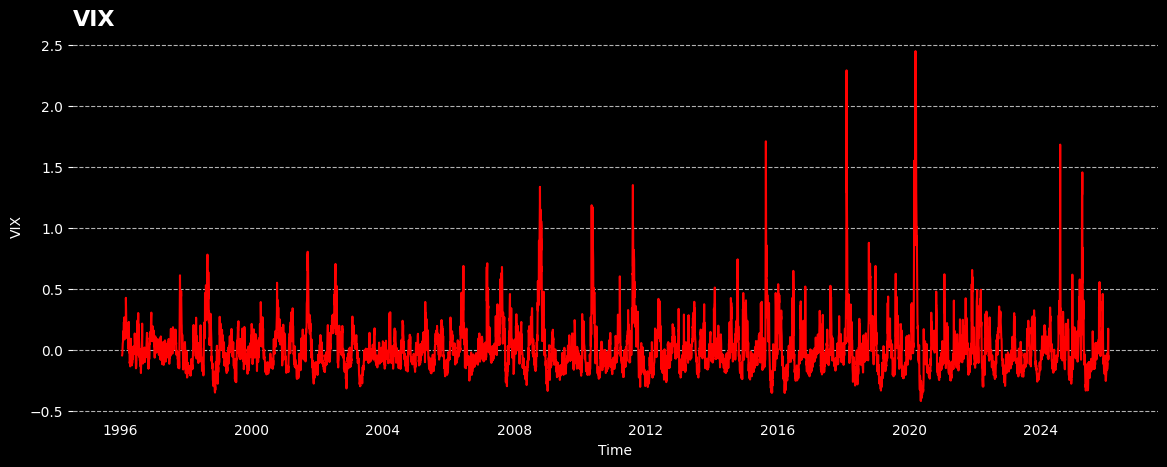

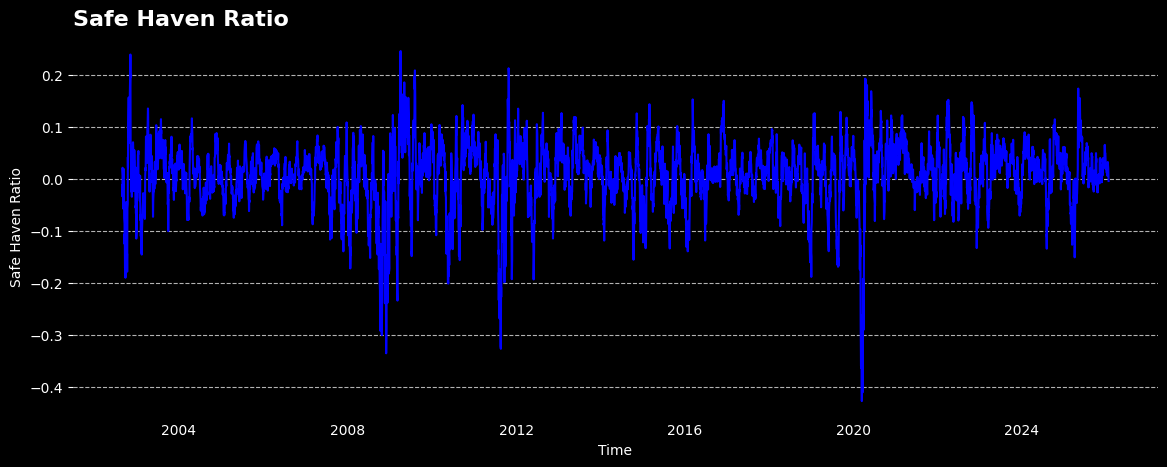

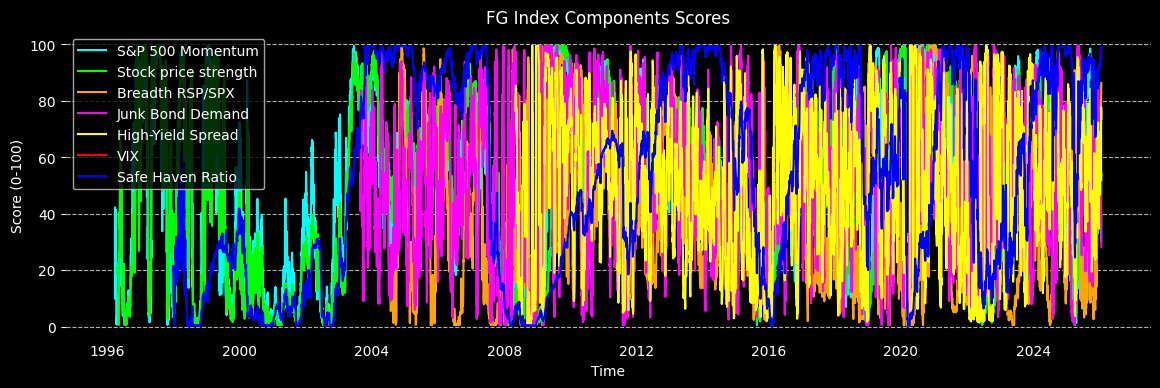

In [8]:
vary = ['raw_momentum_spx', 'raw_strength_proxy', 'raw_breadth_rsp_spx', 'raw_junk_bond_mom_20d', 'raw_hy_spread', 'raw_vix_rel', 'raw_safe_haven_20d']
varscores = ['score_momentum_spx', 'score_strength_proxy', 'score_breadth_rsp_spx', 'score_safe_haven_20d', 'score_junk_bond_mom_20d', 'score_put_call', 'score_hy_spread', 'score_vix_rel']
varnames = ['S&P 500 Momentum', 'Stock price strength', 'Breadth RSP/SPX', 'Junk Bond Demand', 'High-Yield Spread', 'VIX', 'Safe Haven Ratio']
colors = ['cyan', 'lime', 'orange', 'magenta', 'yellow', 'red', 'blue']
for y, name in zip(vary, varnames):
    plotter(fg_df, fg_df.index, y, title=name, ylabel=name, color=colors[vary.index(y)])

plt.figure(figsize=(14, 4))
for y, name, col in zip(varscores, varnames, colors):
    sns.lineplot(data=fg_df, x=fg_df.index, y=y, label=name, color=col)
plt.title("FG Index Components Scores")
plt.xlabel("Time")
plt.ylabel("Score (0-100)")
plt.grid(axis='y', alpha=0.7, linestyle='--')
for sp in plt.gca().spines.values():
    sp.set_visible(False)
ax = plt.gca()
ax.tick_params(axis="x", which="both", length=0)
plt.legend()
plt.show()

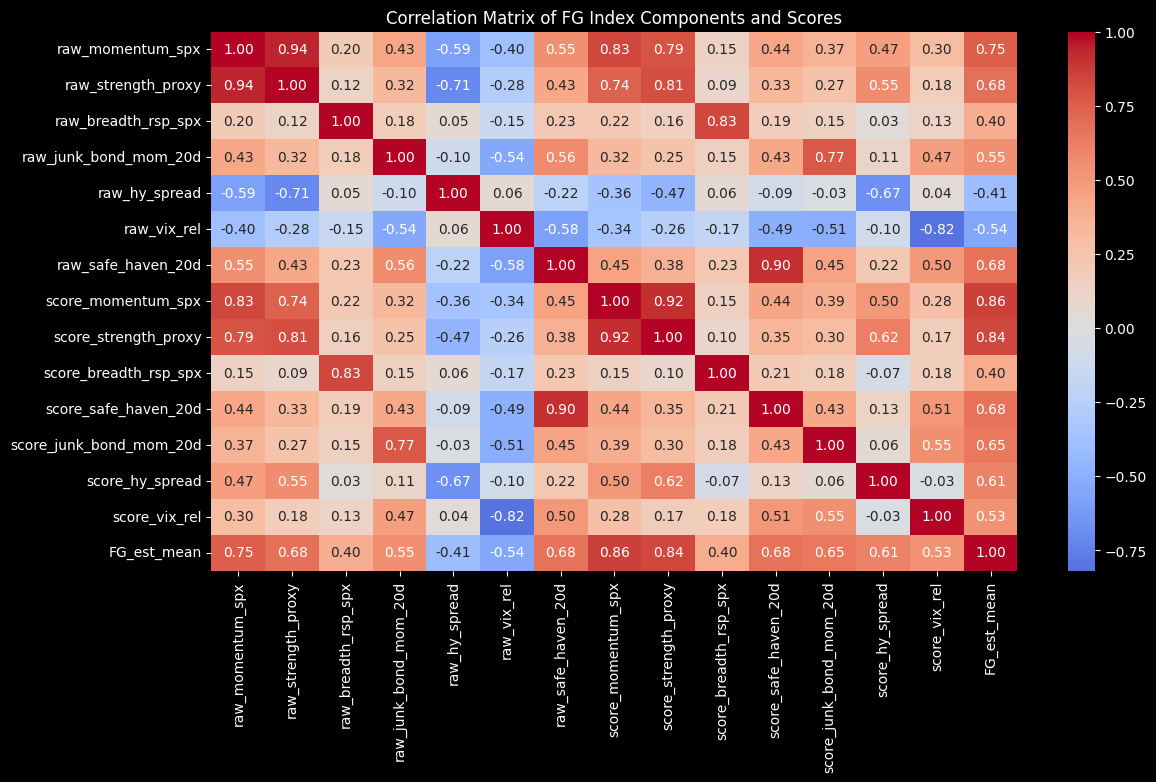

In [9]:
plt.figure(figsize=(13, 7))
no_na_cols = [col for col in fg_df.columns if fg_df[col].isna().all()]
corr = fg_df.drop(columns=no_na_cols).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, )
plt.title("Correlation Matrix of FG Index Components and Scores")
plt.show()

### **<span style="color:blue">FG Indexes comparison</span>**

We will now analyze the results.  
The goal is to compare the estimated score `FG_est_mean` with the original CNN index `FG_CNN` over the period where both are available (2025-01-21 to 2026-01-16).

The estimated F&G Index here is actually obtained by taking the average of the scores of the available components, assuming they are all equally important (equal weighting) in the construction of the final score.

In [10]:
csv_path = "data/fear_greed_cnn_2025_01_21_to_2026_01_16.csv"
cnn_fg = pd.read_csv(csv_path)
cnn_fg.tail()

,date,fear_greed_score,sentiment
248,2026-01-13,59.514286,greed
249,2026-01-14,60.971429,greed
250,2026-01-15,62.171429,greed
251,2026-01-16,62.171429,greed
252,2026-01-16,62.171429,greed


In [11]:
# estimated FG (mean) "market" (fg_df)
if "FG_est_mean" not in fg_df.columns:
    raise KeyError("fg_df ne contient pas 'FG_est_mean' (re-run FG generation)")
fg_series = fg_df["FG_est_mean"].copy()
fg_series.name = "FG_est_mean"
if not fg_series.index.is_unique:
    fg_series = fg_series.groupby(level=0).last()

# True Fear&Greed from CNN (got by scrapping)
ref = cnn_fg.copy()
ref["date"] = pd.to_datetime(ref["date"], errors="coerce")
ref = ref.dropna(subset=["date"]).set_index("date").sort_index()
ref_series = ref["fear_greed_score"].astype(float).copy()
ref_series.name = "Fear&Greed (ref)"
if not ref_series.index.is_unique:
    ref_series = ref_series.groupby(level=0).mean()

### **Findings**

* The metrics show **weak replication** over the common period: ($R^2 \approx 0.50$) and **RMSE ≈ 14 points**.
* Visually, the <span style="color:orange">estimated curve</span> is **too smooth and too high**: it often oscillates between 30 and 70, while the CNN index (cyan) drops much lower. It does not capture extreme "fear" or "greed" phases well.
* The estimator **underreacts to “fear” episodes** (sharp declines, stress spikes) and shows an **upward level bias**, which explains the limited fit quality.

In [12]:
common_idx = fg_series.index.intersection(ref_series.index)
y_true = ref_series.loc[common_idx]
y_pred = fg_series.loc[common_idx]

mean_fg_cnn = np.mean(y_true)
rmse_pred_mean = np.sqrt(mean_squared_error(y_true, np.full_like(y_true, mean_fg_cnn)))

r2_base = r2_score(y_true, y_pred)
rmse_base = np.sqrt(mean_squared_error(y_true, y_pred))
print(">> Performance of the replication")
print(f"-   R-squared: {r2_base:.4f}")
print(f"-   Root Mean Squared Error: {rmse_base:.4f} (vs mean RMSE: {rmse_pred_mean:.4f})")

>> Performance of the replication
-   R-squared: 0.4951
-   Root Mean Squared Error: 13.9708 (vs mean RMSE: 19.6611)


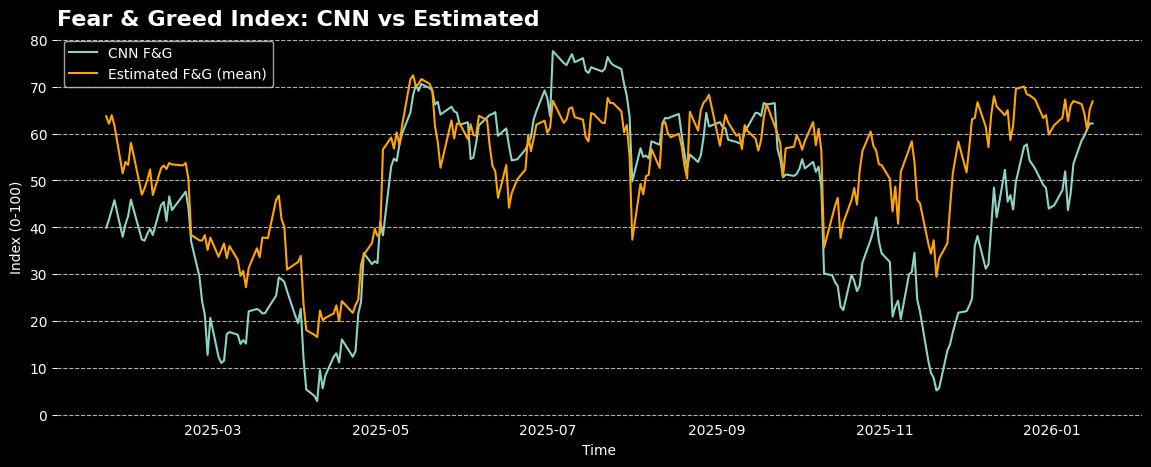

In [13]:
plt_df = pd.DataFrame({
    "CNN Fear&Greed": y_true,
    "Estimated Fear&Greed (mean)": y_pred,
}, index=common_idx)

plt.figure(figsize=(14, 5))
sns.lineplot(data=plt_df["CNN Fear&Greed"], label="CNN F&G")
sns.lineplot(data=plt_df["Estimated Fear&Greed (mean)"], label="Estimated F&G (mean)", color='orange')
plt.title("Fear & Greed Index: CNN vs Estimated", loc='left', fontsize=16, weight='bold')
plt.xlabel("Time")
plt.ylabel("Index (0-100)")
plt.grid(axis='y', alpha=0.7, linestyle='--')
for sp in plt.gca().spines.values():
    sp.set_visible(False)
ax = plt.gca()
ax.tick_params(axis="x", which="both", length=0)
plt.legend()
plt.show()

At the category classification level (Extreme Fear, Fear, Neutral, Greed, Extreme Greed):

* The model **over-predicts “Greed”**:

  * *Greed* class → precision ≈ 0.54, recall ≈ 0.86, F1 ≈ 0.66.
    It correctly identifies periods when CNN is in greed, but does so at the expense of other regimes.

* **Very poor detection of stress phases**:

  * *Extreme Fear* → recall ≈ 0.25 (only a quarter of episodes, despite a precision of 1.00).
  * *Fear* → recall 0.00 (no “Fear” days from CNN are correctly classified).
  * *Neutral* → recall ≈ 0.25, often reclassified as Greed / Extreme Greed.
  * *Extreme Greed* → precision ≈ 0.19, recall ≈ 0.21 (a lot of confusion with Greed).

* **Overall modest performance**:

  * accuracy ≈ 0.45,
  * macro F1 ≈ 0.30 (low when considering all classes, not just Greed).

* The table illustrates this bias: for CNN levels around 40 (*fear* zone), the model frequently outputs an estimate around 60–70 (*greed*) ⇒ **upward bias** and inability to properly capture sentiment drawdowns.

In [14]:
fg_period = ref.loc[common_idx].copy()

estim_fg_period = fg_series.loc[common_idx].copy()
fg_period = fg_period.join(estim_fg_period, how="left")
fg_period.rename(columns={"fear_greed_score": "CNN Fear&Greed", "FG_est_mean": "Estimated Fear&Greed (mean)"}, inplace=True)

# sentiment from estimation
map = [0, 25, 45, 55, 75, 100]
labs = ["extreme fear", "fear", "neutral", "greed", "extreme greed"]

def label_fg(value, bins, labels):
    for i in range(len(bins)-1):
        if bins[i] <= value < bins[i+1]:
            return labels[i]
    return labels[-1]  # last label if value == bins[-1]
fg_period['estimated_sentiment'] = fg_period['Estimated Fear&Greed (mean)'].apply(lambda x: label_fg(x, map, labs))
# fg_period.head()

In [15]:
# Classfication report
y_true_labels = fg_period['CNN Fear&Greed'].apply(lambda x: label_fg(x, map, labs))
y_pred_labels = fg_period['estimated_sentiment']
uplabs = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
print(classification_report(y_true_labels, y_pred_labels, target_names=uplabs))

               precision    recall  f1-score   support

 Extreme Fear       1.00      0.25      0.39        57
         Fear       0.00      0.00      0.00         8
      Neutral       0.28      0.25      0.26        57
        Greed       0.54      0.86      0.66        87
Extreme Greed       0.19      0.21      0.20        42

     accuracy                           0.45       251
    macro avg       0.40      0.31      0.30       251
 weighted avg       0.51      0.45      0.41       251



c:\Users\aurel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aurel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aurel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In conclusion, the current estimator based on proxies and the simple average of component scores fails to faithfully replicate the CNN Fear & Greed Index (**<span style="color:red">~45% accuracy on the situation</span>**).

More sophisticated approaches should be considered, such as:
- **Calibrating optimal weights** for each component via regression or supervised learning methods.
- **Incorporating additional components** if more precise data becomes available (e.g., NYSE highs/lows, McClellan breadth, put/call ratio).
- etc.

In the following sections, we will implement a linear regression to calibrate the component weights and improve the replication of the CNN index.

## **<span style="color:blue">FG Index calibration</span>**

In [16]:
# --- Features (scores des composantes) pour calibration ---
score_cols = [c for c in fg_df.columns if c.startswith("score_")]
if not score_cols:
    raise KeyError("Aucune colonne score_* trouvée dans fg_df (re-run components score creation)")

features = fg_df[score_cols].copy()
if not features.index.is_unique:
    features = features.groupby(level=0).last()

# --- Alignement ---
common_idx = features.index.intersection(ref_series.index).intersection(fg_series.index)
if len(common_idx) == 0:
    raise ValueError("Aucune date commune entre fg_df et cnn_fg")

X = features.loc[common_idx].copy()
y = ref_series.reindex(common_idx).copy()
fg_orig = fg_series.reindex(common_idx).copy()

# Garde uniquement les features avec assez de données
coverage = X.notna().mean()
keep = coverage[coverage >= 0.60].index.tolist()
if not keep:
    keep = coverage[coverage > 0.0].index.tolist()
if not keep:
    raise ValueError("Toutes les features score_* sont vides sur la période commune")
X = X[keep]

# Remplissage simple pour le fit
X = X.ffill().bfill()
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]
fg_orig = fg_orig.loc[mask]

print(X.info())
print(f"X and y shapes: {X.shape, y.shape}")

if len(y) < 30:
    raise ValueError(f"Pas assez de points pour calibrer ({len(y)}).")

<class 'pandas.DataFrame'>
DatetimeIndex: 250 entries, 2025-01-21 to 2026-01-16
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   score_momentum_spx       250 non-null    float64
 1   score_strength_proxy     250 non-null    float64
 2   score_breadth_rsp_spx    250 non-null    float64
 3   score_safe_haven_20d     250 non-null    float64
 4   score_junk_bond_mom_20d  250 non-null    float64
 5   score_hy_spread          250 non-null    float64
 6   score_vix_rel            250 non-null    float64
dtypes: float64(7)
memory usage: 15.6 KB
None
X and y shapes: ((250, 7), (250,))


In [17]:
X_all = fg_df[score_cols].copy()
if not X_all.index.is_unique:
    X_all = X_all.groupby(level=0).last()
print(X_all.shape)

(7547, 8)


In [18]:
model = None

In this section, we will calibrate the weights of each component using a statistical model. Several approaches are possible in this context. To begin, we will use an **ordinary least squares (OLS) linear regression** to estimate the optimal weights of the components.
The idea is to model the CNN index (`FG_CNN`) as a weighted linear combination of the available component scores (`score_*`).

$$
FG\_estimated = \sum_{i} w_i \cdot score\_i + b
$$

In [19]:
def train_calibration_model(
    X: pd.DataFrame,
    y: pd.Series,
    params: Optional[Dict[str, Any]] = None,
    model: str = "lr",
    verbose: bool = False,
    full_output: bool = False,
    X_all: Optional[pd.DataFrame] = None,
    clip: Tuple[float, float] = (0.0, 100.0),
    fill_method: str = "ffill_bfill",
):
    """
    Entraîne un modèle de calibration (régression) pour ajuster les poids des features.

    Returns
    -------
    (mdl, y_pred, info)
      - mdl: estimator sklearn entraîné
      - y_pred: prédiction sur X (Series indexée comme X)
      - info: dict avec métriques + (optionnel) prédiction full + poids

    Notes
    -----
    - model: "lr" (LinearRegression), "ridge" (Ridge), "lasso" (Lasso), "bayesian" (BayesianRidge)
    - X et X_all doivent contenir les mêmes colonnes (au moins celles de X).
    """
    params = params or {}

    model_map = {
        "lr": (LinearRegression, "Linear Regression"),
        "ridge": (Ridge, "Ridge Regression"),
        "lasso": (Lasso, "Lasso Regression"),
        "bayesian": (BayesianRidge, "Bayesian Ridge Regression"),
    }

    if model not in model_map:
        raise ValueError(f"Modèle inconnu: {model}. Choix: {list(model_map.keys())}")

    Estimator, pretty_name = model_map[model]
    mdl = Estimator(**params)
    
    # Sécurité: alignement & types
    X_fit = X.copy()
    y_fit = y.reindex(X_fit.index)

    if fill_method == "ffill_bfill":
        X_fit = X_fit.ffill().bfill()
    elif fill_method == "none":
        pass
    else:
        raise ValueError("fill_method doit être 'ffill_bfill' ou 'none'")

    # Drop lignes où y est NaN
    mask = y_fit.notna()

    X_fit = X_fit.loc[mask]
    y_fit = y_fit.loc[mask]

    mdl.fit(X_fit, y_fit)

    # Prédiction sur X (mêmes lignes que X_fit)
    y_pred = pd.Series(mdl.predict(X_fit), index=X_fit.index, name="y_pred")
    if clip is not None:
        y_pred = y_pred.clip(lower=clip[0], upper=clip[1])

    r2 = r2_score(y_fit, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_fit, y_pred)))

    info = {
        "model": pretty_name,
        "r2": float(r2),
        "rmse": rmse,
        "n_obs": int(len(y_fit)),
        "n_features": int(X_fit.shape[1]),
        "intercept": float(getattr(mdl, "intercept_", np.nan)),
        "coefficients": pd.Series(mdl.coef_, index=X_fit.columns).to_dict(),
    }
    # Optionnel: prédiction sur toute la période (X_all)
    if full_output:
        if X_all is None:
            raise ValueError("X_all must be provided for full_output=True")
        X_full = X_all.copy()

        # on s'assure d'avoir les mêmes colonnes que X_fit
        missing = [c for c in X_fit.columns if c not in X_full.columns]
        if missing:
            raise ValueError(f"X_all ne contient pas les colonnes nécessaires: {missing}")

        X_full = X_full[X_fit.columns]
        if fill_method == "ffill_bfill":
            X_full = X_full.ffill().bfill()

        full_y_pred = pd.Series(mdl.predict(X_full), index=X_full.index, name="y_pred_full")
        if clip is not None:
            full_y_pred = full_y_pred.clip(lower=clip[0], upper=clip[1])

        info["full_y_pred"] = full_y_pred

    if verbose:
        print(f"[{pretty_name}] r2={info['r2']:.4f} rmse={info['rmse']:.4f} "
              f"(n={info['n_obs']}, p={info['n_features']})")

    return mdl, y_pred, info

def diagnostics_calibration(
    y_true: pd.Series,
    y_pred: pd.Series,
    y_base: pd.Series,
    model,
    feature_names,
    model_name: str = "",
    plot: bool = True,
    col: str = "cyan",
):
    y_true = y_true.dropna()
    y_pred = y_pred.reindex(y_true.index).dropna()
    y_base = y_base.reindex(y_true.index).dropna()

    common_idx = y_true.index.intersection(y_pred.index).intersection(y_base.index)
    y_true = y_true.loc[common_idx]
    y_pred = y_pred.loc[common_idx]
    y_base = y_base.loc[common_idx]

    r2_base = r2_score(y_true, y_base)
    rmse_base = np.sqrt(mean_squared_error(y_true, y_base))
    r2_cal = r2_score(y_true, y_pred)
    rmse_cal = np.sqrt(mean_squared_error(y_true, y_pred))

    print("*" * 40)
    print(f"Calibration: {model_name}".strip())
    print("*" * 40)
    print("Période commune:", y_true.index.min().date(), "->", y_true.index.max().date(), f"({len(y_true)} points)")
    print(f"Baseline R2/RMSE: {r2_base:.3f} / {rmse_base:.3f}")
    print(f"After calib R2/RMSE: {r2_cal:.3f} / {rmse_cal:.3f}")
    
    if hasattr(model, "coef_"):
        w = pd.Series(model.coef_, index=list(feature_names), name="weight")
        print("\nTop weights:")
        print(w.sort_values(key=lambda s: s.abs(), ascending=False).head(10))

    if not plot:
        return

    # Time series
    fig, ax = plt.subplots(figsize=(13, 5))
    to_plot = pd.concat([y_base, y_pred, y_true], axis=1).dropna()
    to_plot.columns = ["Estimated F&G (baseline)", f"Estimated F&G ({model_name})", "CNN Fear&Greed"]
    to_plot.plot(ax=ax, linewidth=1.8, color=["orange", col, "cyan"])
    ax.set_title("Fear & Greed: estimated vs baseline (after calibration)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Index (0–100)")
    ax.set_ylim(0, 100)
    ax.legend(loc="upper left")
    ax.grid(axis="y", alpha=0.7, linestyle="--")
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.tick_params(axis="x", which="both", length=0)
    plt.tight_layout()
    plt.show()

    # Scatter before/after
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
    axes[0].set_title("Before (baseline)")
    sns.regplot(
        x=y_base, y=y_true, ax=axes[0],
        scatter_kws={"alpha": 0.5, "s": 18, "color": col},
        line_kws={"color": "white"},
    )
    axes[0].set_xlabel("Estimated FG (baseline)")
    axes[0].set_ylabel("CNN Fear&Greed")
    
    axes[1].set_title("After (calibrated)")
    sns.regplot(
        x=y_pred, y=y_true, ax=axes[1],
        scatter_kws={"alpha": 0.5, "s": 18, "color": col},
        line_kws={"color": "white"},
    )
    axes[1].set_xlabel("Estimated FG (calibrated)")
    axes[1].set_ylabel("")

    for ax in axes:
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

### Linear Regression

****************************************
Calibration: Linear Regression
****************************************
Période commune: 2025-01-21 -> 2026-01-16 (250 points)
Baseline R2/RMSE: 0.495 / 13.971
After calib R2/RMSE: 0.897 / 6.306

Top weights:
score_momentum_spx         0.618505
score_strength_proxy      -0.566059
score_vix_rel              0.247589
score_hy_spread            0.215880
score_safe_haven_20d       0.183380
score_breadth_rsp_spx      0.137149
score_junk_bond_mom_20d    0.118640
Name: weight, dtype: float64


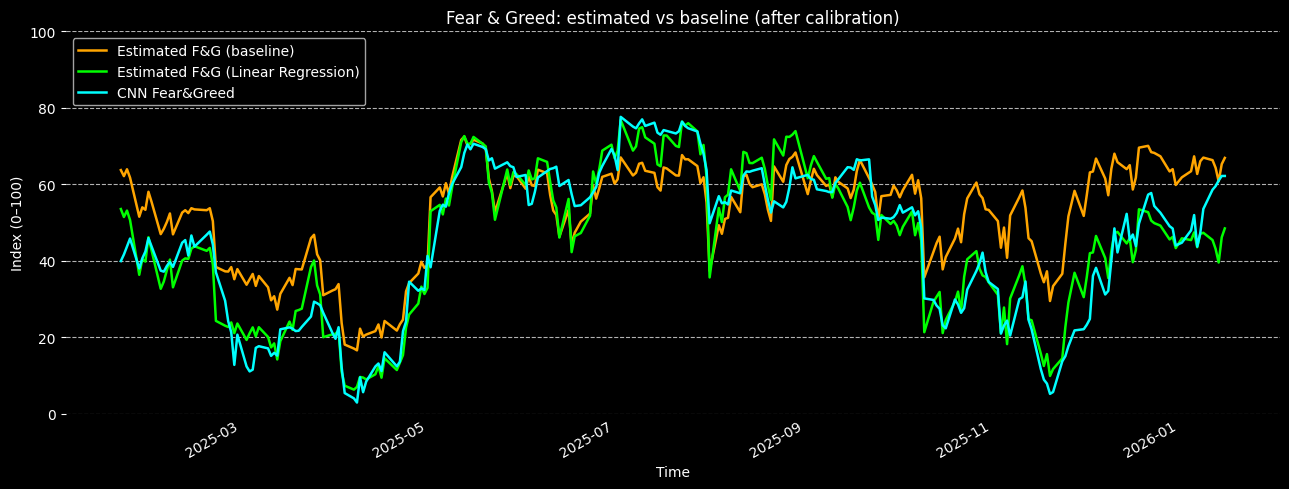

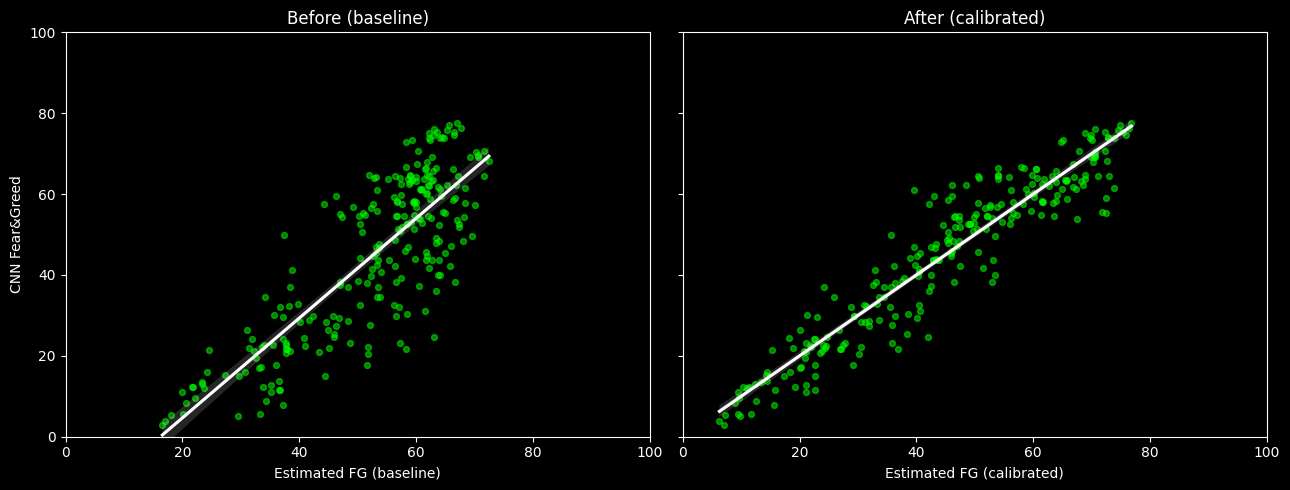

In [20]:
model_lr, y_pred_lr, info_lr = train_calibration_model(X, y, params={}, model="lr", full_output=True, X_all=X_all)

diagnostics_calibration(
    y_true=y,
    y_pred=y_pred_lr,
    y_base=fg_orig,
    model=model_lr,
    feature_names=X.columns,
    model_name=info_lr["model"],
    plot=True,
    col="lime",
)

We will now try to obtain better results by calibrating the component weights using other regularized linear models (Ridge, Bayesian Ridge).

### Ridge Regression

****************************************
Calibration: Ridge Regression
****************************************
Période commune: 2025-01-21 -> 2026-01-16 (250 points)
Baseline R2/RMSE: 0.495 / 13.971
After calib R2/RMSE: 0.897 / 6.306

Top weights:
score_momentum_spx         0.618482
score_strength_proxy      -0.566026
score_vix_rel              0.247591
score_hy_spread            0.215860
score_safe_haven_20d       0.183373
score_breadth_rsp_spx      0.137139
score_junk_bond_mom_20d    0.118649
Name: weight, dtype: float64


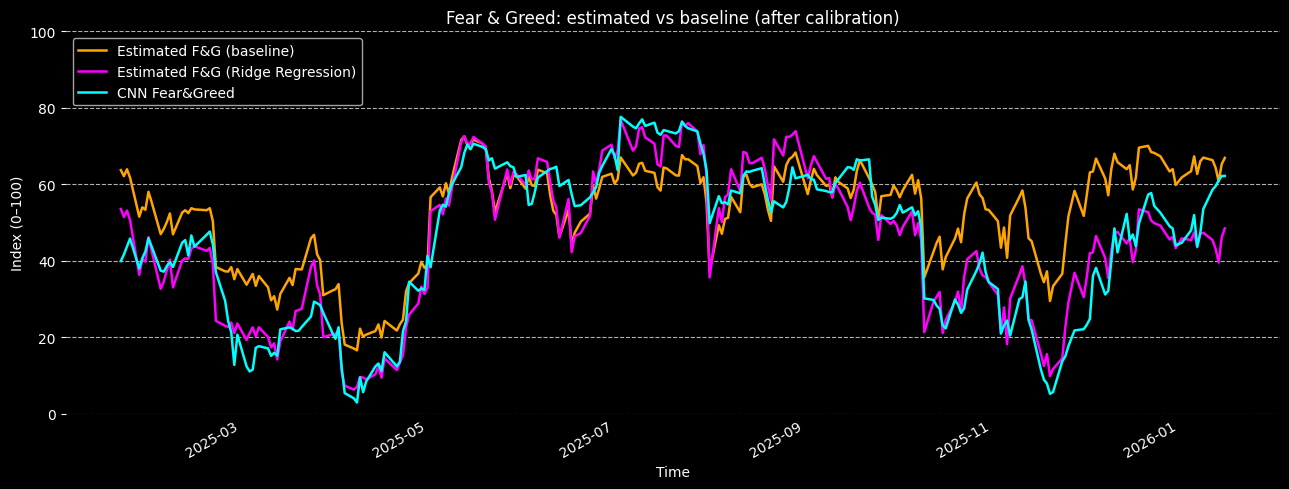

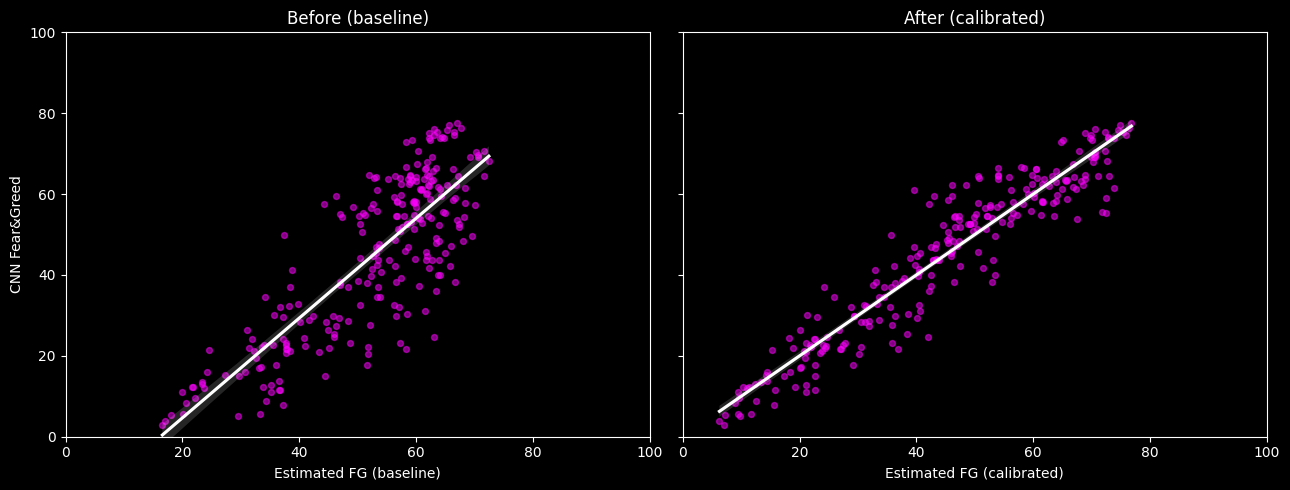

In [21]:
model_rdg, y_pred_rdg, info_rdg = train_calibration_model(X, y, params={"alpha": 1.0}, model="ridge", full_output=True, X_all=X_all)

diagnostics_calibration(
    y_true=y,
    y_pred=y_pred_rdg,
    y_base=fg_orig,
    model=model_rdg,
    feature_names=X.columns,
    model_name=info_rdg["model"],
    plot=True,
    col="magenta",
)

### Bayesian Ridge Regression

****************************************
Calibration: Bayesian Ridge Regression
****************************************
Période commune: 2025-01-21 -> 2026-01-16 (250 points)
Baseline R2/RMSE: 0.495 / 13.971
After calib R2/RMSE: 0.897 / 6.307

Top weights:
score_momentum_spx         0.611076
score_strength_proxy      -0.555268
score_vix_rel              0.248231
score_hy_spread            0.209380
score_safe_haven_20d       0.181194
score_breadth_rsp_spx      0.134104
score_junk_bond_mom_20d    0.121684
Name: weight, dtype: float64


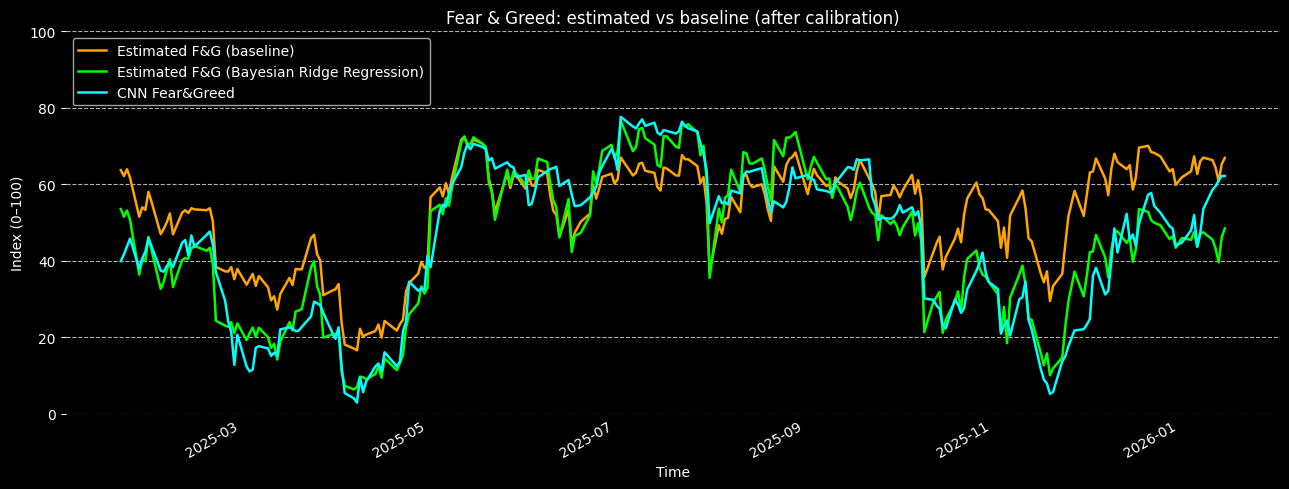

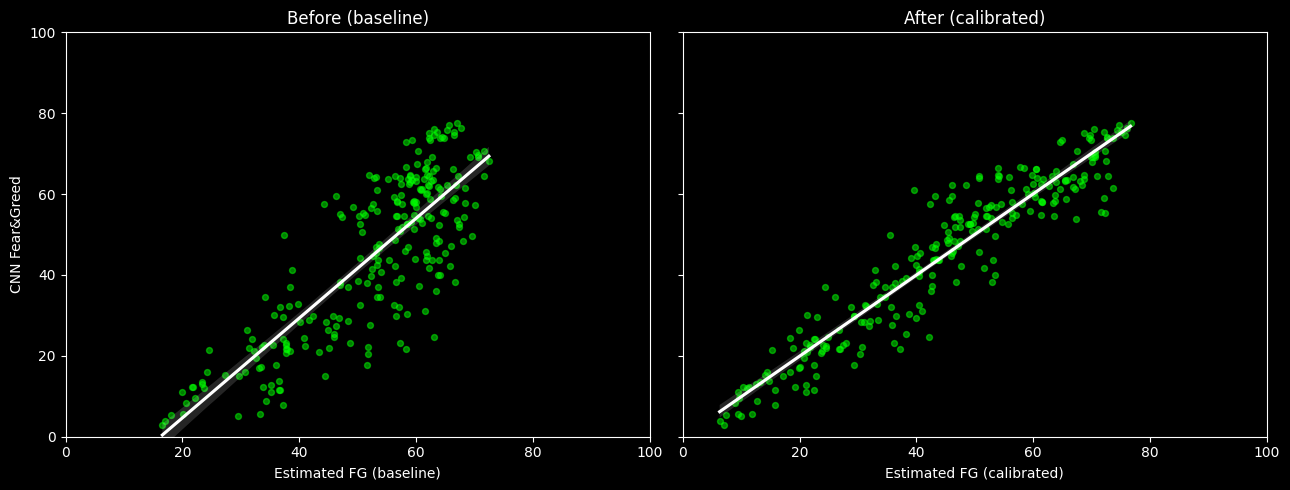

In [22]:
model_brr, y_pred_brr, info_brr = train_calibration_model(X, y, params={}, model="bayesian", full_output=True, X_all=X_all)

diagnostics_calibration(
    y_true=y,
    y_pred=y_pred_brr,
    y_base=fg_orig,
    model=model_brr,
    feature_names=X.columns,
    model_name=info_brr["model"],
    plot=True,
    col="lime",
)

### **Results comparison**

On the validation sample (250 observations), the three tested linear models show **very similar** performance.

> The absence of improvement from regularization (ridge / bayesian ridge) suggests that the problem is **well-conditioned** and that simple linear regression is sufficient to calibrate the index. Therefore, we retain the OLS model as the reference specification.

In [23]:
display(Markdown(f"""
| n° | Models on val            | RMSE | R2 | N obs |
|---|-------------------|---------:|--------:|-------:|
| 1 | {info_lr['model']}      | {info_lr['rmse']:.4f} | {info_lr['r2']:.4f} | {info_lr['n_obs']} |
| 2 | {info_rdg['model']}     | {info_rdg['rmse']:.4f} | {info_rdg['r2']:.4f} | {info_rdg['n_obs']} |
| 3 | {info_brr['model']} | {info_brr['rmse']:.4f} | {info_brr['r2']:.4f} | {info_brr['n_obs']} |
"""))


| n° | Models on val            | RMSE | R2 | N obs |
|---|-------------------|---------:|--------:|-------:|
| 1 | Linear Regression      | 6.3057 | 0.8971 | 250 |
| 2 | Ridge Regression     | 6.3057 | 0.8971 | 250 |
| 3 | Bayesian Ridge Regression | 6.3070 | 0.8971 | 250 |


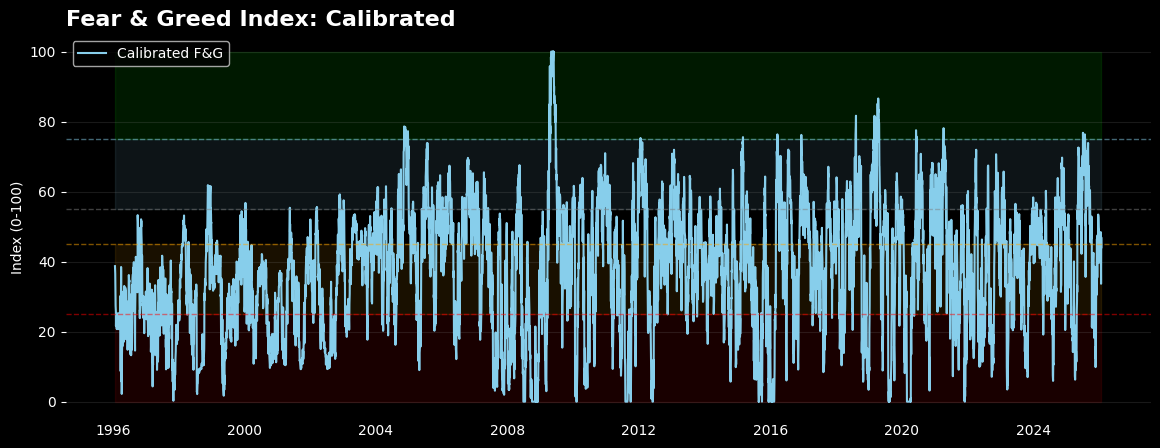

In [24]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=info_lr['full_y_pred'], label="Calibrated F&G", color='skyblue')
plt.title("Fear & Greed Index: Calibrated", loc='left', fontsize=16, weight='bold')
plt.axhline(25, color='red', linestyle='--', alpha=0.5, linewidth=1)
plt.fill_betweenx(y=[0, 25], x1=info_lr['full_y_pred'].index.min(), 
                  x2=info_lr['full_y_pred'].index.max(), color='red', alpha=0.1)
plt.axhline(45, color='orange', linestyle='--', alpha=0.5, linewidth=1)
plt.fill_betweenx(y=[25, 45], x1=info_lr['full_y_pred'].index.min(), 
                  x2=info_lr['full_y_pred'].index.max(), color='orange', alpha=0.1)
plt.axhline(55, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axhline(75, color='skyblue', linestyle='--', alpha=0.5, linewidth=1)
plt.fill_betweenx(y=[55, 75], x1=info_lr['full_y_pred'].index.min(), 
                  x2=info_lr['full_y_pred'].index.max(), color='skyblue', alpha=0.1)
plt.fill_betweenx(y=[75, 100], x1=info_lr['full_y_pred'].index.min(), 
                  x2=info_lr['full_y_pred'].index.max(), color='lime', alpha=0.1)
plt.xlabel("")
plt.ylabel("Index (0-100)")
plt.grid(axis='y', alpha=0.2, color="gray")
for sp in plt.gca().spines.values():
    sp.set_visible(False)
ax = plt.gca()
ax.tick_params(axis="x", which="both", length=0)
plt.legend()
plt.show()

In [25]:
fg_prd = ref.loc[common_idx].copy()

estim_fg_prd = info_lr['full_y_pred'].loc[common_idx].copy()
fg_prd = fg_prd.join(estim_fg_prd, how="left")
fg_prd.rename(columns={"fear_greed_score": "CNN Fear&Greed", "y_pred_full": "Estimated Fear&Greed (lr)"}, inplace=True)

# sentiment from estimation
fg_prd['estimated_sentiment'] = fg_prd['Estimated Fear&Greed (lr)'].apply(lambda x: label_fg(x, map, labs))
fg_prd.head()

,CNN Fear&Greed,sentiment,Estimated Fear&Greed (lr),estimated_sentiment
2025-01-21,39.914286,fear,53.516818,neutral
2025-01-22,41.628571,fear,51.434962,neutral
2025-01-23,43.685714,fear,53.113729,neutral
2025-01-24,45.800000,neutral,50.635590,neutral
2025-01-27,37.971429,fear,36.311932,fear


In [26]:
# Classfication report
y_true_labels = fg_prd['CNN Fear&Greed'].apply(lambda x: label_fg(x, map, labs))
y_pred_labels = fg_prd['estimated_sentiment']
uplabs = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
print(classification_report(y_true_labels, y_pred_labels, target_names=uplabs))

               precision    recall  f1-score   support

 Extreme Fear       0.92      0.82      0.87        57
         Fear       0.75      0.38      0.50         8
      Neutral       0.70      0.81      0.75        57
        Greed       0.86      0.75      0.80        87
Extreme Greed       0.54      0.69      0.60        42

     accuracy                           0.76       251
    macro avg       0.75      0.69      0.70       251
 weighted avg       0.78      0.76      0.76       251



In [27]:
import pickle
model_path = "models/fg_linear_weights.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model_lr, f)

The linear regression model provides overall good classification quality:  
> Accuracy reaches 0.76, with a weighted average F1-score of 0.76 (macro F1 ≈ 0.70).

Extreme regimes are well captured:  
> The *Extreme Fear* class shows excellent precision (0.92) and high recall (0.82), while *Greed* also performs well (precision 0.86, recall 0.75, F1 0.80). The *Neutral* zone is reasonably well identified (precision 0.70, recall 0.81, F1 0.75), showing that the model correctly distinguishes an “intermediate” market sentiment.

However, the *Fear* class remains the weak spot:  
> Despite a precision of 0.75, its recall is only 0.38, meaning a significant portion of actual “Fear” days are absorbed by neighboring classes. Finally, *Extreme Greed* is detected with decent recall (0.69) but more modest precision (0.54), indicating some confusion with the *Greed* class.

## **<span style="color:skyblue">Conclusion</span>**

This project demonstrates the feasibility of a transparent and replicable replication of the CNN Fear & Greed Index using public data and market proxies. The approach involved several steps: collecting financial time series, building raw indicators, transforming them into sentiment scores (0–100), and aggregating them into a composite index.

The naive approach of simply averaging the components captures the general trend of market sentiment but has its limits: the raw replication is too smooth, underreacts to extreme “fear” episodes, and shows an upward bias. Validation metrics over the period shared with the CNN index (R² ≈ 0.50, RMSE ≈ 14) illustrate this lack of precision, especially in detecting stress phases.

Introducing calibration via linear regression (OLS) significantly improves the quality of replication: classification accuracy reaches 76%, with an average F1-score of 0.76. Extreme regimes (“Extreme Fear”, “Greed”) are well identified, while the “Fear” zone remains harder to distinguish, reflecting the intrinsic complexity of market sentiment and the limitations of the proxies used.

In summary, this work highlights:
- The robustness of a composite approach based on public indicators,
- The value of supervised calibration to improve fidelity to the reference index,
- The potential for further improvement, notably by adding new components or using non-linear models.

This pipeline thus provides a solid foundation for market sentiment analysis, academic research, or integration into quantitative strategies, while remaining transparent and adaptable as new data becomes available.